# Laptop Price Prediction #

**Reading Data**

In [48]:
import pandas as pd

df = pd.read_csv('laptop_price.csv', encoding='latin-1')
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


**Preprocessing data**


In [49]:
# When analyzing data, we encounter a few rare companies. Training a model with such a limited dataset could be impossible, so I decided to create a category 'Others' that encompasses all these rare companies.

brand_counts = df['Company'].value_counts()
small_brands = brand_counts[brand_counts < 10].index
df['Company'] = df['Company'].apply(lambda x: "Others" if x in small_brands else x)

In [50]:
# In the dataset, there are a few Operating Systems that can be categorized as more common OSes. To streamline this, I decided to unify certain Operating Systems by replacing specific versions with their more general counterparts.

df['OpSys'] = df['OpSys'].replace({'Windows 10 S': 'Windows 10', 'Mac OS X': 'macOS'})

# In the dataset, some Operating Systems are less common. To improve predictions, I categorized these rare Operating Systems under a unified label named 'OtherSys'. This was accomplished by replacing occurrences of 'Chrome OS' and 'Android' in the 'OpSys' column of the dataframe df with 'OtherSys'.

df['OpSys'] = df['OpSys'].replace(['Chrome OS', 'Android'], 'OtherSys')

In [51]:
# The 'Memory' column contains both the value and type of memory. I created a new column named 'Memory_Type' and extracted the type of memory using regex. This provided me with a column containing valuable information regarding the type of memory in each device, whether it's SSD, HDD, or Flash Storage.

df['Memory_Type'] = df['Memory'].str.extract(r'(SSD|HDD|Flash Storage)', expand=False)

In [52]:
# The 'Memory' column contains values specified in GB and TB. To standardize these values, I converted all of them to GB and removed the units. This process resulted in numeric values all in a single unit of measurement, GB, making the data more consistent and easier to analyze.

import re
def convert_to_gb(value):
    unit_map = {'TB': 1024, 'GB': 1}
    match = re.search(r'(\d+)(TB|GB)', value, re.IGNORECASE)
    if match:
        num, unit = match.groups()
        return float(num) * unit_map[unit.upper()]
    else:
        return None

df['Memory_size_GB'] = df['Memory'].apply(convert_to_gb)

In [53]:
# The 'Cpu' column contains information about both the processor model and its clock frequency. To better organize this data, I split it into two separate columns. Using a lambda function, I separated the processor model and clock frequency at the last space character, resulting in two new columns: 'Processor' for the processor model and 'Clock' for the clock frequency.

df[['Processor', 'Clock']] = df['Cpu'].apply(lambda x: pd.Series(str(x).rsplit(' ', 1)))

In [54]:
# To streamline the processor information, I implemented a function called trim_processor to remove less relevant parts of the description. This function checks if the processor description starts with 'Intel'; if so, it retains only the first three words of the description. For other processors, it keeps the first two words.

def trim_processor(value):
    if value.startswith('Intel'):
        return ' '.join(value.split(' ', 3)[:3])
    else:
        return ' '.join(value.split(' ', 2)[:2])

df['Processor'] = df['Processor'].apply(trim_processor)

In [55]:
# To provide better learning models I ograniczyłem number of Processors and changed rare processors to Others

cpu_counts = df['Processor'].value_counts()
rare_cpu = cpu_counts[cpu_counts < 10].index
df['Processor'] = df['Processor'].apply(lambda x: "Others" if x in rare_cpu else x)

In [56]:
# In the columns 'Clock', 'Ram', and 'Weight', the units are consistent, so I decided to remove the units to obtain numeric values. This was achieved by applying transformation functions to each column.

df['Clock'] = df['Clock'].apply(lambda x: float(str(x).strip("GHz")))
df['Ram'] = df["Ram"].apply(lambda x: int(str(x).strip("GB")))
df['Weight'] = df["Weight"].apply(lambda x: float(str(x).strip("kg")))

In [57]:
# To disregard non-essential information, I opted to eliminate all detailed GPU information and retain only the brand. This was accomplished by creating a new column 'Gpu_Brand' in the dataframe df. I extracted the brand from the 'Gpu' column by splitting each entry at the first space and keeping only the first part, which typically represents the brand name. This approach simplifies the GPU data to focus solely on the brand, which might be sufficient for modeling purposes.

df['Gpu_Brand'] = df['Gpu'].str.split(n=1, expand=True)[0]

In [58]:
# To obtain a numeric value and simplify the screen resolution information, I decided to limit the 'Screen Resolution' data to just the 'Screen Width'. This was done by creating a new column named 'Screen_Width' in the dataframe `df'. I extracted the width from the 'ScreenResolution' column by splitting each entry from the right at the last space, taking the last part which typically contains the resolution (e.g., '1920x1080'), and then splitting this by 'x' to separate width from height. I kept only the width (the first part) and converted it to an integer. This method effectively reduces the screen resolution data to a single, numeric width value, making it more straightforward for numerical analysis or modeling.

df['Screen_Width'] = df['ScreenResolution'].str.rsplit(' ', n=1).str[-1].str.split('x').str[0].astype(int)

In [59]:
# After extracting the relevant data, I remove unnecessary columns from the dataframe to streamline it.
df = df.drop(['laptop_ID', 'Product', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu'], axis=1)

In [60]:
# Now we can see how DataFrame looks
df.head()

,Company,TypeName,Inches,Ram,OpSys,Weight,Price_euros,Memory_Type,Memory_size_GB,Processor,Clock,Gpu_Brand,Screen_Width
0,Apple,Ultrabook,13.3,8,macOS,1.37,1339.69,SSD,128.0,Intel Core i5,2.3,Intel,2560
1,Apple,Ultrabook,13.3,8,macOS,1.34,898.94,Flash Storage,128.0,Intel Core i5,1.8,Intel,1440
2,HP,Notebook,15.6,8,No OS,1.86,575.00,SSD,256.0,Intel Core i5,2.5,Intel,1920
3,Apple,Ultrabook,15.4,16,macOS,1.83,2537.45,SSD,512.0,Intel Core i7,2.7,AMD,2880
4,Apple,Ultrabook,13.3,8,macOS,1.37,1803.60,SSD,256.0,Intel Core i5,3.1,Intel,2560


**Cleaning data**

In [61]:
any_nan = df.isnull().values.any()
any_nan

True

In [62]:
df.dropna()
df.drop_duplicates(keep='first', inplace=True)

def remove_outliers(df, columns):
    indices_to_remove = set()

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_indices = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
        indices_to_remove.update(outliers_indices)

    df_cleaned = df.drop(indices_to_remove)

    return df_cleaned
df = remove_outliers(df, ['Price_euros', "Inches", 'Ram'])

**Splitting data**

In [63]:
from sklearn.model_selection import train_test_split

X = df.drop('Price_euros', axis=1)
y = df['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

**One Hot Encoding**

In [64]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
columns_to_encode=['Company','TypeName', 'OpSys', 'Memory_Type', 'Gpu_Brand', "Processor"]
encoder.fit(X_train[columns_to_encode])

X_train_encoded = encoder.transform(X_train[columns_to_encode])
X_test_encoded = encoder.transform(X_test[columns_to_encode])

X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out(columns_to_encode), index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out(columns_to_encode), index=X_test.index)

X_train_dropped = X_train.drop(columns=columns_to_encode)
X_test_dropped = X_test.drop(columns=columns_to_encode)

X_train_final = pd.concat([X_train_dropped, X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test_dropped, X_test_encoded_df], axis=1)

In [65]:
X_train_final.dtypes

Inches                          float64
Ram                               int64
Weight                          float64
Memory_size_GB                  float64
Clock                           float64
Screen_Width                      int32
Company_Acer                    float64
Company_Apple                   float64
Company_Asus                    float64
Company_Dell                    float64
Company_HP                      float64
Company_Lenovo                  float64
Company_MSI                     float64
Company_Others                  float64
Company_Toshiba                 float64
TypeName_2 in 1 Convertible     float64
TypeName_Gaming                 float64
TypeName_Netbook                float64
TypeName_Notebook               float64
TypeName_Ultrabook              float64
TypeName_Workstation            float64
OpSys_Linux                     float64
OpSys_No OS                     float64
OpSys_OtherSys                  float64
OpSys_Windows 10                float64


**Normalization**

In [66]:
mean_values = X_train_final.mean()
std_values = X_train_final.std()

print("Średnie wartości dla każdej kolumny:\n", mean_values)
print("\nOdchylenia standardowe dla każdej kolumny:\n", std_values)

Średnie wartości dla każdej kolumny:
 Inches                            15.020197
Ram                                6.662562
Weight                             1.966943
Memory_size_GB                   452.615764
Clock                              2.274951
Screen_Width                    1843.349754
Company_Acer                       0.084975
Company_Apple                      0.016010
Company_Asus                       0.108374
Company_Dell                       0.224138
Company_HP                         0.243842
Company_Lenovo                     0.235222
Company_MSI                        0.018473
Company_Others                     0.038177
Company_Toshiba                    0.030788
TypeName_2 in 1 Convertible        0.080049
TypeName_Gaming                    0.084975
TypeName_Netbook                   0.004926
TypeName_Notebook                  0.657635
TypeName_Ultrabook                 0.153941
TypeName_Workstation               0.018473
OpSys_Linux                        0.0

In [67]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_final)
X_train_scaled = scaler.transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_final.columns, index=X_train_final.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_final.columns, index=X_test_final.index)


**Regression**

In [68]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train_scaled_df, y_train)
y_pred_linear = linear_model.predict(X_test_scaled_df)
print(f'Coefficients: {linear_model.coef_}')

Coefficients: [ 1.80921484e+01  7.99181050e+01 -5.65137755e+01  6.71096501e+00
  6.00430643e+01  7.95664681e+01 -3.17975589e+14  4.26063003e+13
 -3.54474867e+14 -4.75533150e+14 -4.89656596e+14 -4.83656816e+14
 -1.53549929e+14 -2.18514969e+14 -1.96984566e+14 -7.85397368e+12
 -8.07033224e+12 -2.02632050e+12 -1.37330022e+13 -1.04449373e+13
 -3.89715117e+12 -1.70843072e+14 -1.76226035e+14 -7.90077056e+13
 -2.85865167e+14 -1.37697948e+14 -2.80451396e+14 -3.02819113e+14
 -7.27066878e+14 -7.47293244e+14 -1.19971850e+14 -5.71731662e+14
 -5.55609031e+13 -7.75784834e+14 -6.80261120e+14  4.25977888e+12
  5.47876685e+12  8.59350448e+12  4.25977888e+12  1.39774687e+13
  1.98822518e+13  1.88440476e+13  5.47876685e+12  9.01110472e+12]


In [69]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=1.2)
lasso_model.fit(X_train_scaled_df, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled_df)
print(f'Coefficients: {lasso_model.coef_}')


Coefficients: [   1.72269841   81.84841879  -44.14405049    2.46371534   58.18565727
   79.48822938  -25.22877913   11.21140698  -14.72515048   -0.
   29.43126665   16.28617371   -0.42019781   -3.20937982   25.14141855
    0.           -6.18804711   11.74535827 -104.59765737   18.40532918
   65.20774545  -20.74375811  -50.10744698    2.3184557     0.
   47.4494995     4.14219022   -8.42570025   -0.           53.14791173
  -15.80382284  -17.68690965   -3.2957482    11.43874517   -0.
  -20.21086446  -20.01223969   -9.14174132    6.84329257   -4.69904433
   66.13157557  118.52988987   -0.          -22.31791093]


In [70]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled_df, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled_df)
print(f'Coefficients: {ridge_model.coef_}')


Coefficients: [ 16.56628474  79.24592442 -55.62116052   6.83004163  59.31824389
  79.77374174 -29.76645339   9.05403641 -21.00007011  -6.70213176
  22.71280454  11.16305671  -4.83828128  -7.40102506  23.55415934
  18.70908709  13.11840362  18.49531582 -74.61912242  42.43599027
  74.7251797  -16.68894938 -47.32898967   7.90486524   8.52267874
  52.82085394   9.05403641 -17.97062777 -23.01738888  32.89678959
 -20.05902202 -17.85778991  -4.68373317  13.11574487   0.4338046
 -32.7565092  -35.59738753 -31.8048297   -2.59131075 -41.48164519
  16.75739179  71.8054355  -14.31432316 -45.4026313 ]


In [71]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train_scaled_df)
X_test_poly = poly_features.transform(X_test_scaled_df)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)
print(f'Coefficients: {poly_model.coef_}')

Coefficients: [-2.48760407e+11  1.19696688e+11  1.48290586e+11 ...  2.33957994e+11
  7.67104714e+10  3.66684919e+11]


In [72]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor(max_depth=3, min_samples_split=6)
tree_model.fit(X_train_scaled_df, y_train)
y_pred_tree = tree_model.predict(X_test_scaled_df)


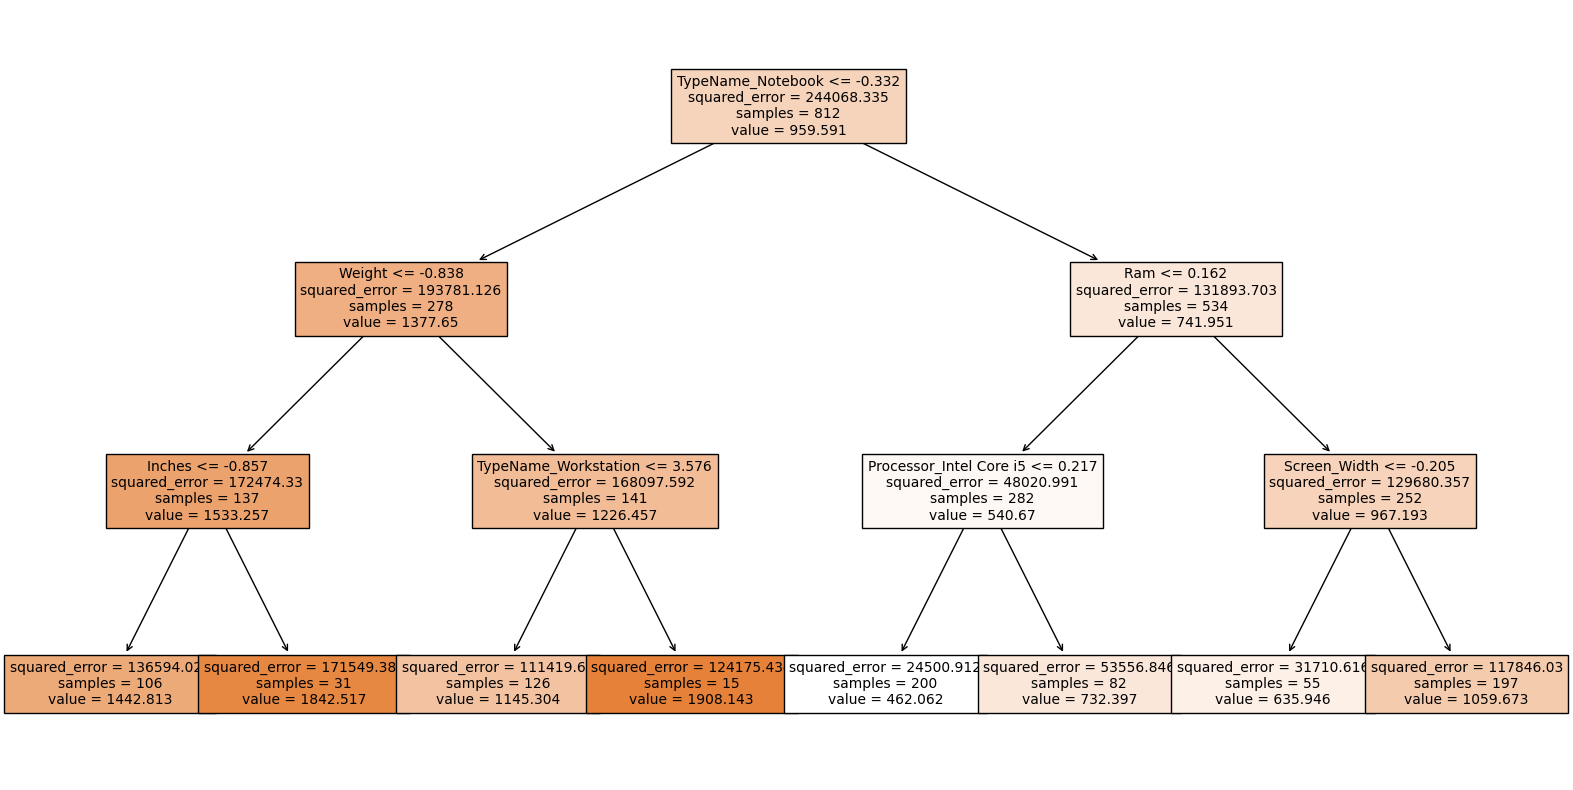

In [73]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(tree_model, filled=True, feature_names=X_test_scaled_df.columns, max_depth=3, fontsize=10)
plt.show()


**Evaluation**

In [74]:
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
model_names = ['Linear', 'Lasso', 'Ridge', 'Polynomial', 'Decision Tree']
predictions = [y_pred_linear, y_pred_lasso, y_pred_ridge, y_pred_poly, y_pred_tree]
results = []

for model_name, pred in zip(model_names, predictions):
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    r_mse = root_mean_squared_error(y_test, pred)
    results.append({"Model": model_name, "MSE": mse, "R2": r2, "RMSE": r_mse})

results_df = pd.DataFrame(results)
results_df[['MSE', 'R2', 'RMSE']] = results_df[['MSE', 'R2', 'RMSE']].map(lambda x: f'{x:.4f}')


In [75]:
results_df

,Model,MSE,R2,RMSE
0,Linear,53096.6002,0.7095,230.4270
1,Lasso,52913.8941,0.7105,230.0302
2,Ridge,53048.1878,0.7097,230.3219
3,Polynomial,3741713746961585596792832.0000,-20474102814062571520.0000,1934350988564.7913
4,Decision Tree,75471.6096,0.5870,274.7210


The metrics of the polynomial model are significantly worse compared to other models. Moreover, the R^2 score is below 0. In the next step, I will check for potential overfitting of the model.

In [76]:
y_train_pred_poly = poly_model.predict(X_train_poly)
train_r2 = r2_score(y_train, y_train_pred_poly)
train_rmse = root_mean_squared_error(y_train, y_train_pred_poly)

test_r2 = r2_score(y_test, y_pred_poly)
test_rmse = root_mean_squared_error(y_test, y_pred_poly)

print(f"Training R^2: {train_r2}, Training RMSE: {train_rmse}")
print(f"Test R^2: {test_r2}, Test RMSE: {test_rmse}")

Training R^2: 0.8985650094526381, Training RMSE: 157.3437930907544
Test R^2: -2.047410281406257e+19, Test RMSE: 1934350988564.7913


Enormous difference between metric values for training and testing data indicates that the model is overfitted. A solution to this problem may be simplifying the model by reducing the number of features or complexity, or increasing the training data size to improve the model's generalization capability.